# Explore multimapper % in TRA/TRB/TRG/TRD productive vs nonproductive

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sb
from itertools import compress
import random
import scirpy as ir
import os
import rpy2
%load_ext rpy2.ipython

sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]

In [2]:
sb.set_palette('colorblind')

In [3]:
# import utils
import sys
sys.path.append('/home/jovyan/chenqu_utils')
from array_operations import *

In [4]:
# set working directory
%cd /lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/

/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript


In [5]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/VDJ_collab/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

# Load data

### abTCR

In [7]:
path = '/lustre/scratch117/cellgen/team205/sharedData/cs42/all-dandelion-paper-map/'

In [8]:
# load metadata
meta = pd.read_csv('metadata/PBMC_manifest.csv')

In [9]:
meta

,Donor,organ,age,Date_of_sample,Sample,10x kit,target_recovery,cells_loaded,sample_no,sanger_sample_ID,sequence_name,BCR,TCR
0,Stemcells,PBMC,adult,19/07/2022,AM1_treated,5'v2.0,10000,17653,1,AM1_treated,HCA_F_Imm13086136,HCA_F_Imm13086148,HCA_F_Imm13086142
1,Stemcells,PBMC,adult,19/07/2022,AM1_control,5'v2.0,10000,16698,2,AM1_control,HCA_F_Imm13086137,HCA_F_Imm13086149,HCA_F_Imm13086143


In [10]:
# load all contigs
vdj = None
for lane_id, gex_id in zip(meta['TCR'], meta['sequence_name']):
    if os.path.exists(path+lane_id+'/dandelion/tmp/all_contig_igblast_db-all.tsv'):
        df = pd.read_csv(path+lane_id+'/dandelion/tmp/all_contig_igblast_db-all.tsv', delimiter='\t', index_col='sequence_id',dtype='object')
    else:
        # for samples with no contigs in db-pass
        df = pd.read_csv(path+lane_id+'/dandelion/tmp/all_contig_igblast_db-fail.tsv', delimiter='\t', index_col='sequence_id',dtype='object')
    
    
    # update index column with lane_id info
    df.index = gex_id +'-'+ df.index
    
    # concatenate files from different samples
    if vdj is None:
        vdj = df.copy()
    else:
        vdj = pd.concat([vdj, df], sort=False)
    
    print(lane_id)

HCA_F_Imm13086142
HCA_F_Imm13086143


In [11]:
vdj_ab = vdj.loc[vdj['locus'].isin(['TRA','TRB']),:]

## BCR

In [12]:
# load all contigs
vdj2 = None
for lane_id, gex_id in zip(meta['BCR'], meta['sequence_name']):
    if os.path.exists(path+lane_id+'/dandelion/tmp/all_contig_igblast_db-all.tsv'):
        df = pd.read_csv(path+lane_id+'/dandelion/tmp/all_contig_igblast_db-all.tsv', delimiter='\t', index_col='sequence_id',dtype='object')
    else:
        # for samples with no contigs in db-pass
        df = pd.read_csv(path+lane_id+'/dandelion/tmp/all_contig_igblast_db-fail.tsv', delimiter='\t', index_col='sequence_id',dtype='object')
    
    
    # update index column with lane_id info
    df.index = gex_id +'-'+ df.index
    
    # concatenate files from different samples
    if vdj2 is None:
        vdj2 = df.copy()
    else:
        vdj2 = pd.concat([vdj2, df], sort=False)
    
    print(lane_id)

HCA_F_Imm13086148
HCA_F_Imm13086149


In [13]:
vdj_bcr = vdj2.loc[vdj2['locus'].isin(['IGH', 'IGK', 'IGL']),:]

# Check % of multimappers

In [14]:
# concatenate abtcr and gdtcr, bcr
vdj_combine = pd.concat([vdj_ab,vdj_bcr])
# set sample column
vdj_combine['sample'] = [barcode.split('-')[0] for barcode in vdj_combine.index]

vdj_combine['v_gene_present'] = ~(vdj_combine['v_call'].isna())

# duplicate_count is the umi count
vdj_combine['duplicate_count'] = vdj_combine['duplicate_count'].astype('float')

add celltype information

In [15]:
obs = pd.read_csv('csv/PBMC_cycloheximide_obs.csv',index_col=0)

In [16]:
vdj_combine['cell_barcode'] = [name[-25:-9] for name in vdj_combine.index]
vdj_combine['sample_cell_barcode'] = vdj_combine['sample']+'-'+vdj_combine['cell_barcode']

In [17]:
vdj_combine['celltype'] = lookup(vdj_combine['sample_cell_barcode'], obs, -1, 'majority_voting')
vdj_combine['condition'] = 'control'
vdj_combine.loc[vdj_combine['sample']=='HCA_F_Imm13086136','condition'] = 'treated'

In [18]:
vdj_combine.to_csv('csv/PBMC_cycloheximide_vdj_combine.csv')

In [6]:
vdj_combine = pd.read_csv('csv/PBMC_cycloheximide_vdj_combine.csv',index_col=0)

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (93,94,95,96,97,98,99,100,101,102,103) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Only leave contigs in a cell - as the other contigs might be ambient RNA

In [7]:
vdj_cell = vdj_combine[~vdj_combine['celltype'].isna()]

In [8]:
# remove contigs with j_call_multimappers being NaN - i.e. no j_call from blastn as our cutoff is more stringent than igblastn
vdj_cell = vdj_cell.loc[~vdj_cell['j_call_multiplicity'].isna(),:]

In [9]:
# add column of j multimappers are present or not
vdj_cell['j_multi_present'] = vdj_cell['j_call_multiplicity'].astype('float') > 1

In [10]:
# take out the leftmost j gene in j_call_multimappers
vdj_cell['j_call_leftmost'] = [gene.split(';')[0] for gene in vdj_cell['j_call_multimappers']]

In [11]:
# 4 columns that we care about in plotting
group_by=['condition','locus','v_gene_present','j_multi_present']

# make dataframe df
df = vdj_cell[group_by].drop_duplicates()
df = df[group_by].astype("str")
df.index = df[group_by].agg("-".join, axis=1)

# add column 'count' in df
vdj_cell[group_by] = vdj_cell[group_by].astype("str")
vdj_cell["condition-locus-v-j"] = vdj_cell[group_by].agg("-".join, axis=1)
count = vdj_cell.groupby('condition-locus-v-j').count().iloc[:,0]
df['count'] = 0
df['count'].update(count)

# add column with condition-locus-v
df['condition-locus-v'] = df[group_by[:-1]].agg("-".join, axis=1)

df

,condition,locus,v_gene_present,j_multi_present,count,condition-locus-v
treated-TRB-True-False,treated,TRB,True,False,4231,treated-TRB-True
treated-TRA-True-False,treated,TRA,True,False,4882,treated-TRA-True
treated-TRB-False-False,treated,TRB,False,False,1762,treated-TRB-False
treated-TRB-False-True,treated,TRB,False,True,2181,treated-TRB-False
treated-TRA-False-False,treated,TRA,False,False,458,treated-TRA-False
treated-TRB-True-True,treated,TRB,True,True,58,treated-TRB-True
treated-TRA-False-True,treated,TRA,False,True,35,treated-TRA-False
treated-TRA-True-True,treated,TRA,True,True,57,treated-TRA-True
control-TRB-True-False,control,TRB,True,False,4284,control-TRB-True
control-TRB-False-True,control,TRB,False,True,1092,control-TRB-False


In [12]:
# make new dataframe df_new to calculate percentage of j multimappers present
df_new = pd.DataFrame(index = set(df['condition-locus-v']))
df_new['j_multi_present'] = True

# add columns of condition, locus, v_gene_present
df_new['condition'] = [name.split('-')[0] for name in df_new.index]
df_new['locus'] = [name.split('-')[1] for name in df_new.index]
df_new['v_gene_present'] = [name.split('-')[2] for name in df_new.index]

# add new column of condition-locus-v-j to find count from df
df_new[group_by] = df_new[group_by].astype("str")
df_new['condition-locus-v-j'] = df_new[group_by].agg("-".join, axis=1)
df_new['count'] = lookup(df_new['condition-locus-v-j'], df, -1, 'count')
df_new['count'] = df_new['count'].fillna(0)

# add column 'total_count' - total count is total no. of contigs for each condition-locus-v 
df_new['total_count'] = 0
total_count = df.groupby('condition-locus-v').sum().iloc[:,0]
df_new['total_count'].update(total_count)

# calculate percentage of count/total_count
df_new['j_multi_perc'] = df_new['count'] / df_new ['total_count'] * 100

df_new

,j_multi_present,condition,locus,v_gene_present,condition-locus-v-j,count,total_count,j_multi_perc
control-IGK-True,True,control,IGK,True,control-IGK-True-True,0.0,1317,0.000000
control-IGL-True,True,control,IGL,True,control-IGL-True-True,0.0,719,0.000000
treated-IGL-False,True,treated,IGL,False,treated-IGL-False-True,0.0,47,0.000000
treated-IGK-True,True,treated,IGK,True,treated-IGK-True-True,0.0,1088,0.000000
control-TRA-False,True,control,TRA,False,control-TRA-False-True,23.0,346,6.647399
treated-TRA-True,True,treated,TRA,True,treated-TRA-True-True,57.0,4939,1.154080
treated-IGK-False,True,treated,IGK,False,treated-IGK-False-True,0.0,120,0.000000
control-IGH-True,True,control,IGH,True,control-IGH-True-True,81.0,1392,5.818966
control-TRB-True,True,control,TRB,True,control-TRB-True-True,32.0,4316,0.741427
treated-IGH-True,True,treated,IGH,True,treated-IGH-True-True,86.0,1495,5.752508


In [13]:
df_new['locus-v'] = df_new['locus'] +'-'+df_new['v_gene_present']

In [14]:
df_new

,j_multi_present,condition,locus,v_gene_present,condition-locus-v-j,count,total_count,j_multi_perc,locus-v
control-IGK-True,True,control,IGK,True,control-IGK-True-True,0.0,1317,0.000000,IGK-True
control-IGL-True,True,control,IGL,True,control-IGL-True-True,0.0,719,0.000000,IGL-True
treated-IGL-False,True,treated,IGL,False,treated-IGL-False-True,0.0,47,0.000000,IGL-False
treated-IGK-True,True,treated,IGK,True,treated-IGK-True-True,0.0,1088,0.000000,IGK-True
control-TRA-False,True,control,TRA,False,control-TRA-False-True,23.0,346,6.647399,TRA-False
treated-TRA-True,True,treated,TRA,True,treated-TRA-True-True,57.0,4939,1.154080,TRA-True
treated-IGK-False,True,treated,IGK,False,treated-IGK-False-True,0.0,120,0.000000,IGK-False
control-IGH-True,True,control,IGH,True,control-IGH-True-True,81.0,1392,5.818966,IGH-True
control-TRB-True,True,control,TRB,True,control-TRB-True-True,32.0,4316,0.741427,TRB-True
treated-IGH-True,True,treated,IGH,True,treated-IGH-True-True,86.0,1495,5.752508,IGH-True


In [15]:
# only keep the ones with total_count >=10
df_plot = df_new[df_new['total_count']>=10]

In [16]:
df1 = df_plot[df_plot['v_gene_present']=='True']
df2 = df_plot[df_plot['v_gene_present']=='False']

In [17]:
df3 = df1.copy()
for condition in set(df3['condition']):
    name1 = condition+'-IGL-True'
    name2 = condition+'-IGK-True'
    df3.loc[name1, 'count'] = df1.loc[name1, 'count'] + df1.loc[name2, 'count']
    df3.loc[name1, 'total_count'] = df1.loc[name1, 'total_count'] + df1.loc[name2, 'total_count']
    df3.loc[name1, 'j_multi_perc'] = df1.loc[name1, 'j_multi_perc'] + df1.loc[name2, 'j_multi_perc']
    df3.loc[name1, 'locus'] = 'IGL/IGK'

In [18]:
df3 = df3[df3['locus'].isin(['TRA','TRB','IGH','IGL/IGK'])]

In [19]:
df3['locus'] = df3['locus'].astype('category')
df3['locus'] = df3['locus'].cat.reorder_categories(['TRA','TRB','IGH','IGL/IGK'])
df3['condition'] = df3['condition'].astype('category')
df3['condition'] = df3['condition'].cat.reorder_categories(['control','treated'])

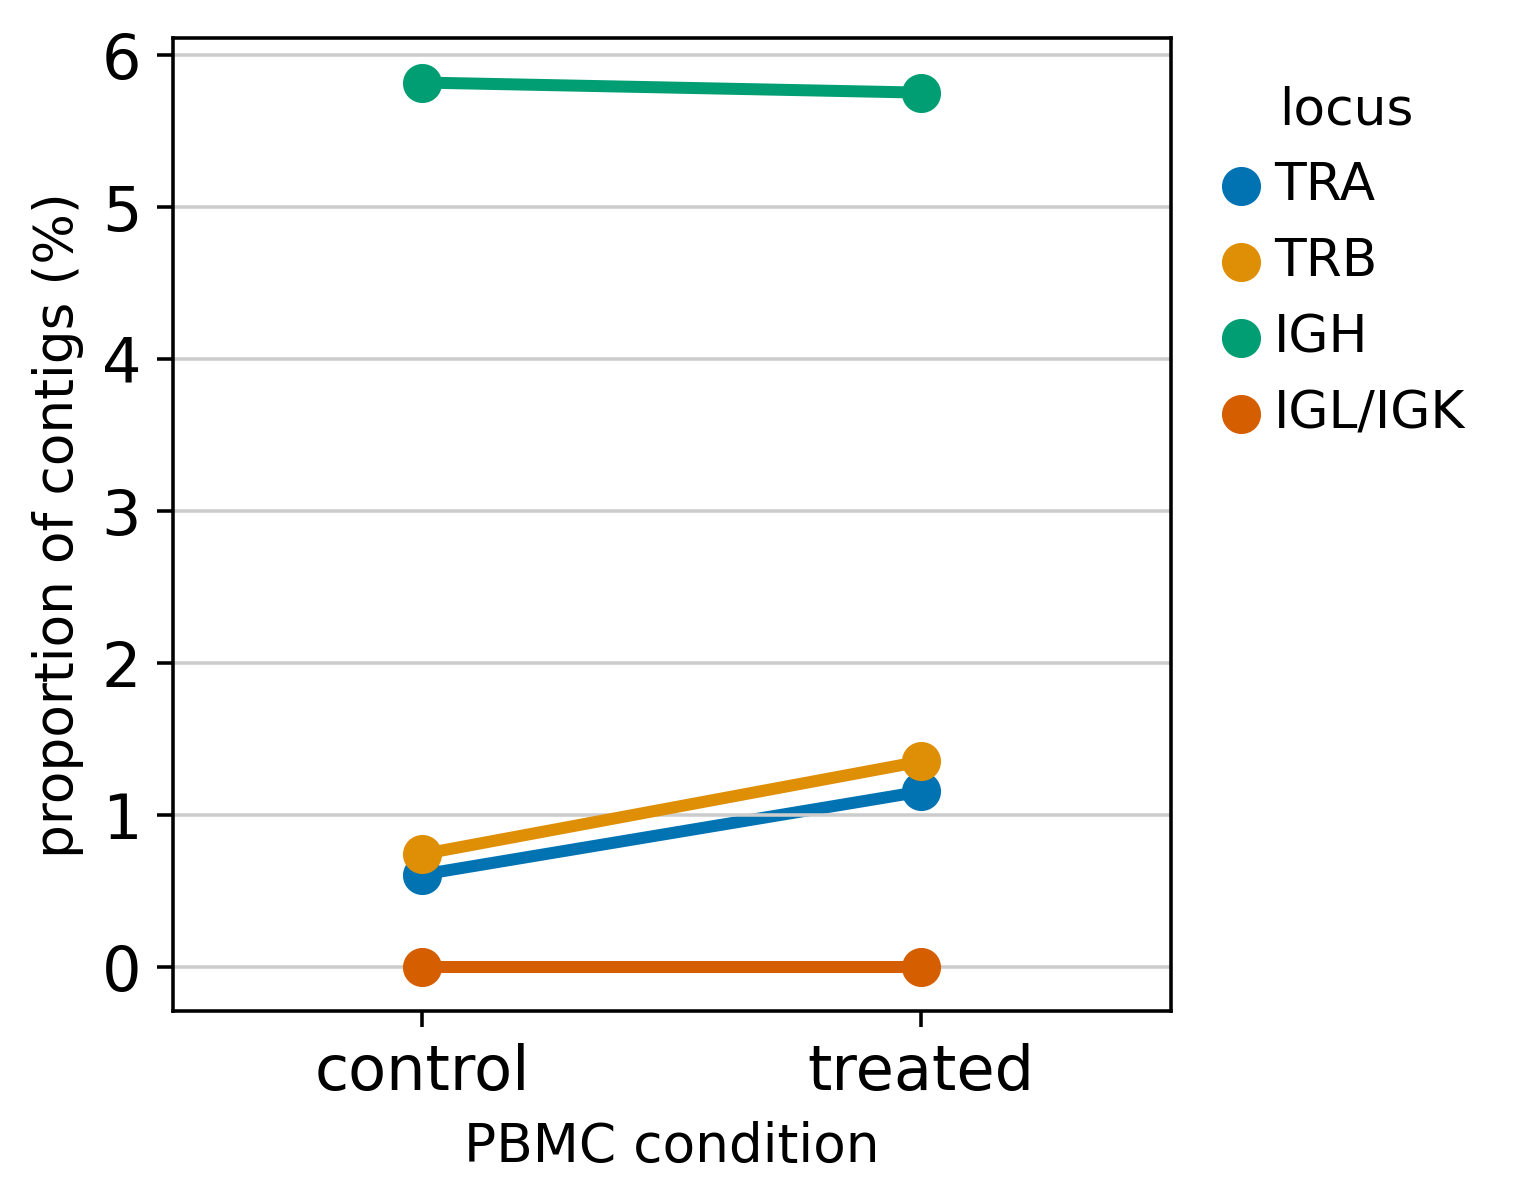

In [20]:
plt.rcParams["figure.figsize"] = [4,4]
#fig, ax =plt.subplots(figsize=(3,3))
ax = sb.pointplot(x="condition", y="j_multi_perc", hue="locus",gitter=True,
             data=df3,
             linestyles="-")
plt.ylabel('proportion of contigs (%)',fontsize=12)
plt.xlabel('PBMC condition',fontsize=12)
plt.title('',fontsize=12) 
h,l = ax.get_legend_handles_labels()
plt.rcParams['legend.title_fontsize'] = 'small'
l1 = ax.legend(h,l,title='locus', loc='upper left',frameon=False, bbox_to_anchor=(1.01, 1),fontsize='small')
plt.savefig(fig_path+'PBMC_j_multimapper.pdf',bbox_inches='tight');

# Logistic regression to look at what influence J_multimappers & whether this is different btw the 2 samples

In [21]:
df = vdj_cell[['j_multi_present','sample','celltype','locus','v_gene_present','j_call_leftmost','condition']]

In [22]:
df.loc[df['j_multi_present']=='True','j_multi_present'] = 1
df.loc[df['j_multi_present']=='False','j_multi_present'] = 0
df['j_multi_present'] = df['j_multi_present'].astype('int')

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-22-e863c489146d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['j_multi_present']=='True','j_multi_present'] = 1
<ipython-input-22-e863c489146d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['j_multi_present']=='Fals

In [24]:
%%R -i df

fit <- glm(j_multi_present ~ celltype + v_gene_present*condition + j_call_leftmost, data=df, family='binomial')
results = as.data.frame(summary(fit)$coefficients)
results$adj_pval = p.adjust(results$`Pr(>|z|)`, method = 'BH')

write.csv(results, 'csv/LR_results_combined.csv')
write.csv(results, '/home/jovyan/mount/gdrive/VDJ_collab/manuscript/supplement/LR_results_combined.csv')

In [25]:
%%R
results[c('v_gene_presentTrue','conditiontreated','v_gene_presentTrue:conditiontreated'),]

                                      Estimate Std. Error    z value
v_gene_presentTrue                  -3.7892507 0.12324702 -30.745172
conditiontreated                    -0.1471270 0.08826057  -1.666962
v_gene_presentTrue:conditiontreated  0.5154501 0.14580806   3.535127
                                         Pr(>|z|)      adj_pval
v_gene_presentTrue                  1.418710e-207 1.773388e-205
conditiontreated                     9.552194e-02  2.609927e-01
v_gene_presentTrue:conditiontreated  4.075786e-04  2.315787e-03


# Confirm that NMD is inhibited by looking at nonproductive to productive umi ratio

In [219]:
df = pd.DataFrame(index = set(vdj_cell['sample_cell_barcode']), columns = ['productive_umi','nonpro_umi','nonprod_noV','nonprod_premature_stop','nonprod_frameshift'])

In [220]:
for cell in df.index:
    a = np.array(vdj_cell['sample_cell_barcode']==cell)
    select = vdj_cell.loc[a,:]
    
    b = np.array(select['productive']=='T')
    c = np.array(select['productive']=='F')
    d = np.array(select['v_gene_present']=='False')
    e = np.array(select['stop_codon']=='T')
    f = np.array(select['vj_in_frame']=='F')
    
    df.loc[cell, 'productive_umi'] = np.sum(select.loc[b,'duplicate_count'])
    df.loc[cell, 'nonpro_umi'] = np.sum(select.loc[c,'duplicate_count'])
    
    df.loc[cell, 'nonprod_noV'] = np.sum(select.loc[c & d,'duplicate_count'])
    df.loc[cell, 'nonprod_premature_stop'] = np.sum(select.loc[c & e,'duplicate_count'])
    
    x = c & f
    y = x & ~d # v_gene_present == True
    z = y & ~e # stop_codon =='F'
    df.loc[cell, 'nonprod_frameshift'] = np.sum(select.loc[z,'duplicate_count'])

In [221]:
df['condition'] = lookup(df.index, vdj_cell, 'sample_cell_barcode','condition')

In [223]:
tbl = df.groupby(['condition']).sum()

In [242]:
df['nonprod_prod']=df['nonpro_umi'].astype('int')/(df['productive_umi'].astype('int')+df['nonpro_umi'].astype('int'))
df['noV_prod']=df['nonprod_noV'].astype('int')/(df['productive_umi'].astype('int')+df['nonpro_umi'].astype('int'))
df['stop_prod']=df['nonprod_premature_stop'].astype('int')/(df['productive_umi'].astype('int')+df['nonpro_umi'].astype('int'))
df['frameshift_prod']=df['nonprod_frameshift'].astype('int')/(df['productive_umi'].astype('int')+df['nonpro_umi'].astype('int'))

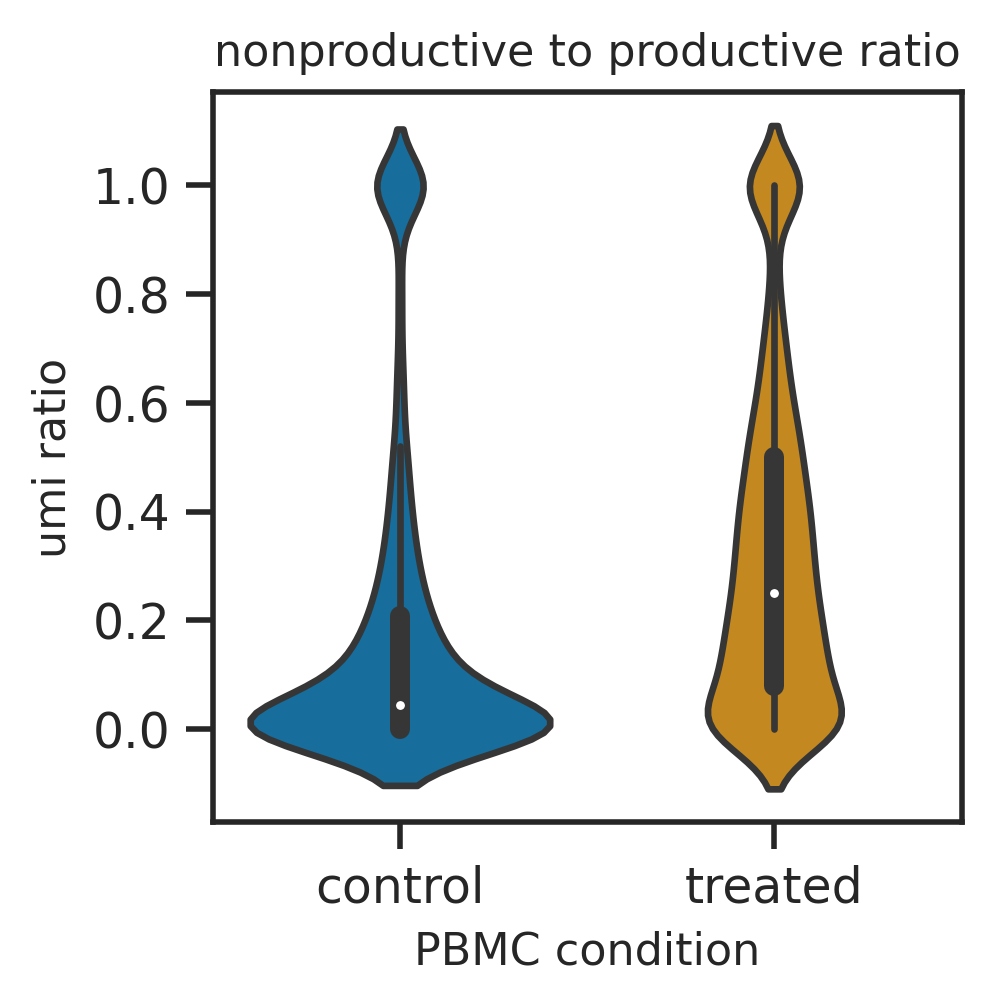

In [243]:
sb.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(3,3))

ax = sb.violinplot(data=df, x="condition", y="nonprod_prod",palette='colorblind')
plt.ylabel('umi ratio',fontsize=10)
plt.xlabel('PBMC condition',fontsize=10)
plt.title('nonproductive to productive ratio',fontsize=10) 

plt.savefig(fig_path+'PBMC_nonprod_to_prod.pdf',bbox_inches='tight');

<AxesSubplot:xlabel='condition', ylabel='frameshift_prod'>

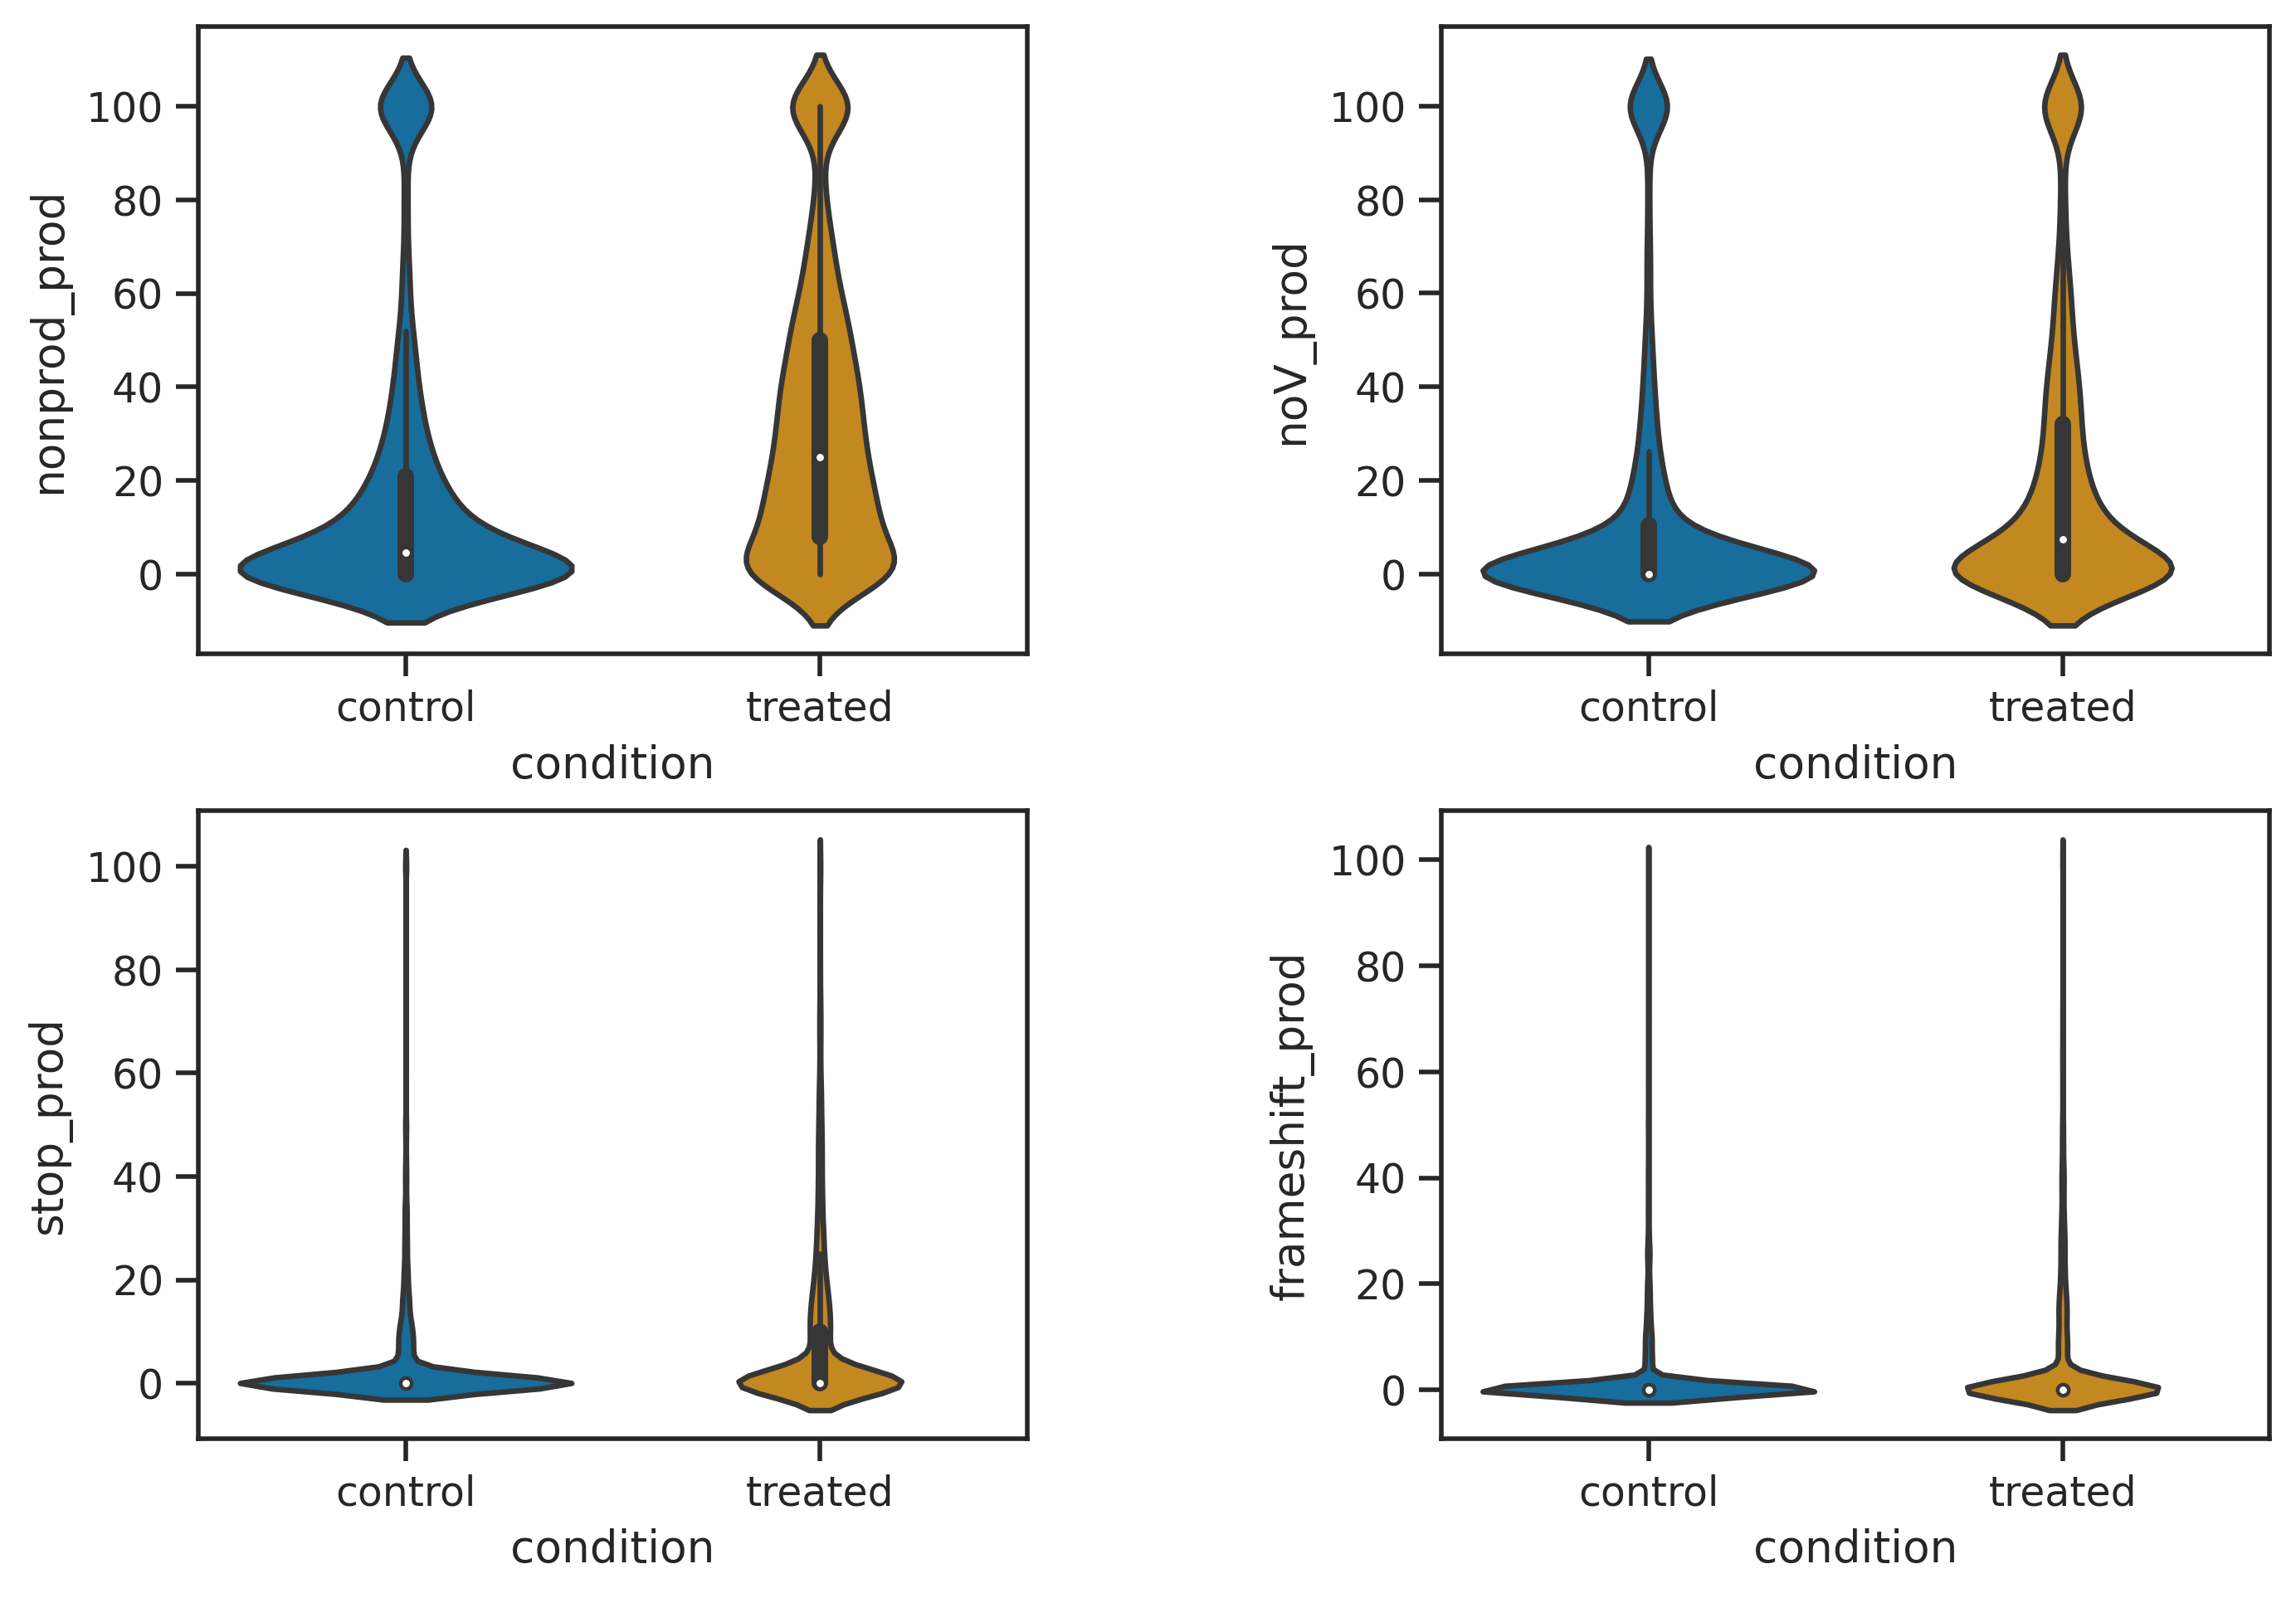

In [225]:
sb.set_theme(style="ticks")
fig, ax = plt.subplots(2,2,figsize=(10,7))
plt.subplots_adjust(wspace=0.5,hspace=0.25)

sb.violinplot(data=df, x="condition", y="nonprod_prod",ax=ax[0,0],palette='colorblind')
sb.violinplot(data=df, x="condition", y="noV_prod",ax=ax[0,1],palette='colorblind')
sb.violinplot(data=df, x="condition", y="stop_prod",ax=ax[1,0],palette='colorblind')
sb.violinplot(data=df, x="condition", y="frameshift_prod",ax=ax[1,1],palette='colorblind')

In [207]:
np.mean(df.loc[df['condition']=='treated','nonprod_prod']) / np.mean(df.loc[df['condition']=='control','nonprod_prod'])

1.829519632759255

In [239]:
tbl_perc = tbl / np.array(np.sum(tbl.iloc[:,[0,1]], axis=1)).reshape(2,1) * 100

In [240]:
tbl_perc

,productive_umi,nonpro_umi,nonprod_noV,nonprod_premature_stop,nonprod_frameshift
condition,,,,,
control,92.847561,7.152439,4.600991,1.21342,1.336583
treated,75.660259,24.339741,14.350768,5.93420,4.013915
